# PROYECTO FINAL

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

Objetivo: identificar operadores ineficaces

## Importación de librerías

In [7403]:
# importación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

## Lectura de archivos

In [7404]:
# Lectura de dataset de llamadas
calls = pd.read_csv('telecom_dataset_us.csv')
calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [7405]:
# Lectura del dataset de clientes 
clients = pd.read_csv('telecom_clients_us.csv')
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


## Preprocesamiento de los datos

### Llamadas

#### Tipos de datos y valores ausentes

In [7406]:
# Revisar columnas, tipos de datos y valores asusentes
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


El dataset presenta 117 valores ausentes en las columnas de internal, correspondiente a un 0,21% de los datos. Esta columna tiene como información si la llamada fue interna ó externa, por lo cual podemos conservar estos datos tal cual están.

La columna operator_id tiene 8.172 valores ausentes, correspondiente al 15% del total de los datos. Nuestro objetivo principal es identificar los operadores ineficaces, por lo cual, conservar estas filas no aportan valor para nuestro análisis y pueden provocar ruido, además representan un pocentaje relativamente bajo de los datos (15%) como para no dañar el dataset en caso de eliminarlos. 
Pensar en reemplazarlos con algún otro no es viable, ya que es un valor único de identificación, por lo cual, la mejor decisión es retirarlos de nuestro análisis, pero los conservaremos en un dataset diferente por si en algún momento se requieren.

In [7407]:
# Conservar datos de operadores sin identificación
operator_nulls = calls[calls['operator_id'].isnull()]

In [7408]:
# Eliminar valores ausentes de operator id
calls = calls.dropna(subset=['operator_id'])

# Revisamos nuevamente el dataset
calls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45730 non-null  int64  
 1   date                 45730 non-null  object 
 2   direction            45730 non-null  object 
 3   internal             45670 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       45730 non-null  bool   
 6   calls_count          45730 non-null  int64  
 7   call_duration        45730 non-null  int64  
 8   total_call_duration  45730 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.2+ MB


Se han eliminado 8172 filas que no contenian identificación del operador, y dentro de estas habían 57 que también tenían ausencia en la columna internal. Por lo cual, pasamos de 117 a 60 valores ausentes en la columna internal, los cuales se conservarán como están.

El nuevo dataset tiene la columna 'date' como string y 'operator_id' como float64, por lo cual se les asignaran los tipos de datos correctos.

In [7409]:
calls['date'].min(), calls['date'].max()

('2019-08-02 00:00:00+03:00', '2019-11-28 00:00:00+03:00')

La columna 'date' tiene huso horario + 3:00 lo que quiere decir que su hora representa 3 horas más adelante. Lo particular, es que todas las filas tienen exactamente la misma hora, por lo que no podríamos evaluar la variación de llamadas durante el día. Siendo así, es irrelevante dejar la marca de la hora.

In [7410]:
# Asignar tipo de dato correcto a las columnas
calls['date'] = pd.to_datetime(calls['date'], errors='coerce')
calls['date'] = calls['date'].dt.tz_localize(None) 
calls['operator_id'] = calls['operator_id'].astype('Int64')
calls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45730 non-null  int64         
 1   date                 45730 non-null  datetime64[ns]
 2   direction            45730 non-null  object        
 3   internal             45670 non-null  object        
 4   operator_id          45730 non-null  Int64         
 5   is_missed_call       45730 non-null  bool          
 6   calls_count          45730 non-null  int64         
 7   call_duration        45730 non-null  int64         
 8   total_call_duration  45730 non-null  int64         
dtypes: Int64(1), bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 3.2+ MB


#### Valores duplicados

In [7411]:
# Valores duplicados
calls[calls.duplicated(keep=False)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05,out,False,880020,True,8,0,50
8,166377,2019-08-05,out,False,880020,True,8,0,50
43,166377,2019-08-14,out,False,880026,False,10,1567,1654
44,166377,2019-08-14,out,False,880026,False,10,1567,1654
46,166377,2019-08-15,out,False,880026,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53874,168601,2019-11-26,in,False,952914,False,4,539,562
53883,168603,2019-11-20,out,False,959118,True,3,0,89
53885,168603,2019-11-20,out,False,959118,True,3,0,89
53899,168606,2019-11-15,out,True,957922,False,4,3130,3190


Hay 8368 filas con exactamente la misma información en todas las columnas, cliente, fecha, dirección, operador, cantidad, duración son valores que dificilmente podríar ser tan exactamente iguales, por lo que puedo concluir que si son duplicados que tal vez se incluyeron por un mal registro de la información. Las filas duplicadas a eliminar representan un 9,15% de los datos puesto que solo se borra una de las filas duplicadas. Sin embargo al igual que los valores ausentes en la columna de 'operator_id' los dejaremos en un dataset separado por si se llegaran a necesitar en algún momento del análisis. 

In [7412]:
# Eliminación de duplicados
calls = calls.drop_duplicates()
calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
5,166377,2019-08-05,out,False,880020,False,2,3,29


#### Valores atípicos

In [7413]:
calls.describe().round(2)

,user_id,date,operator_id,calls_count,call_duration,total_call_duration
count,41546.00,41546,41546.0,41546.00,41546.00,41546.00
mean,167301.31,2019-10-23 15:57:50.370192128,916523.32,16.90,1009.77,1321.59
min,166377.00,2019-08-02 00:00:00,879896.0,1.00,0.00,0.00
25%,166782.00,2019-10-06 00:00:00,900790.5,1.00,0.00,67.00
50%,167175.00,2019-10-28 00:00:00,913938.0,4.00,106.00,288.00
75%,167827.00,2019-11-14 00:00:00,937708.0,13.00,770.00,1104.00
max,168606.00,2019-11-28 00:00:00,973286.0,4817.00,144395.00,166155.00
std,600.42,NaN,21230.04,59.75,4064.11,4785.98


Hay valores atípicos fuertes, especialmente en:
1. calls_count donde la media es 16,9, pero el valor máximo es 4817, un valor muy por encima del 75% percentil (13).
2. call_duration donde el valor máximo es 144395 y la media es 1009.77	
3. total_call_duration, el valor máximo de 166155 y media de 1321.59

In [7414]:
# Establecemos umbrales para la detección de outliers
filtered_calls = calls[(calls['calls_count'] <= 500) & (calls['call_duration'] <= 5000) & (calls['total_call_duration'] <= 100000)].copy() 

filtered_calls.describe().round(2)

,user_id,date,operator_id,calls_count,call_duration,total_call_duration
count,39876.00,39876,39876.0,39876.00,39876.00,39876.00
mean,167292.31,2019-10-23 19:43:51.477580544,916373.81,11.80,534.24,758.21
min,166377.00,2019-08-02 00:00:00,879896.0,1.00,0.00,0.00
25%,166782.00,2019-10-06 00:00:00,900790.0,1.00,0.00,63.00
50%,167162.00,2019-10-29 00:00:00,913788.0,4.00,87.00,258.00
75%,167816.00,2019-11-14 00:00:00,937604.0,12.00,626.00,930.00
max,168606.00,2019-11-28 00:00:00,973286.0,499.00,4998.00,17146.00
std,594.32,NaN,21141.17,26.18,924.95,1199.98


In [7415]:
# Número de operadores únicos
print(f'Número de operadores únicos: {calls["operator_id"].nunique()}')

Número de operadores únicos: 1092


### Clientes

#### Tipos de datos y valores ausentes

In [7416]:
# Revisar columnas, tipos de datos y valores ausentes
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


No hay valores ausentes. 

La columna 'date_start' tiene tipo string, por lo cual se convertirá a datetime.

In [7417]:
# Asignar tipo de dato a la columna 'date_start' como datetime
clients['date_start'] =pd.to_datetime(clients['date_start'])

In [7418]:
# Revisar duplicados
print(f'Filas duplicadas en el dataset Clients: {clients.duplicated().sum()}')

Filas duplicadas en el dataset Clients: 0


In [7419]:
# Cantidad de clientes por tarifa 
clients.groupby('tariff_plan')['user_id'].count()

tariff_plan
A     76
B    261
C    395
Name: user_id, dtype: int64

De los 732 usuarios registrados, 395 están en el tarifa C lo cual corresponde al 53,96%, mientras que en la tarifa B hay 261 usuarios con el 35,65% y en la tarifa A, 76 usuarios con el 10,38%.

## Análisis exploratorio

### Distribución de clientes por tafira

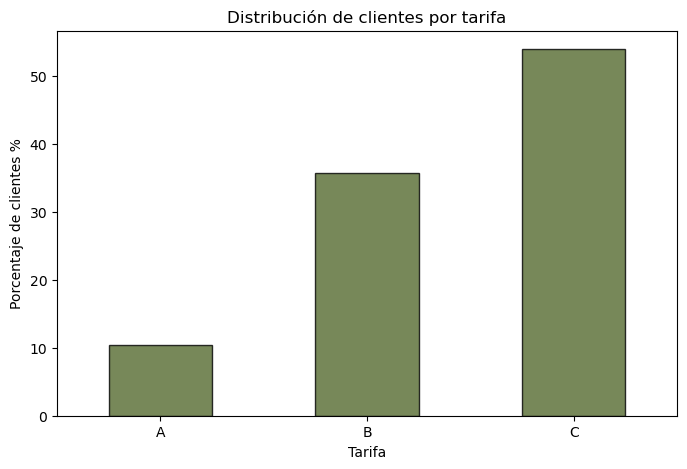

In [7420]:
# Total de Clientes
total_clientss = clients['user_id'].nunique()

# Agrupamos clientes por tarifa
clients_by_tariff = clients.groupby('tariff_plan')['user_id'].count()

# Porcentaje de clientes por tarifa
clients_by_tariff = clients_by_tariff / total_clientss * 100
clients_by_tariff.plot(kind='bar',  
                         color='#556B2F', 
                         figsize=(8, 5),
                         edgecolor='black',
                         alpha=0.8,
                         title='Distribución de clientes por tarifa',
                         xlabel='Tarifa',
                         ylabel='Porcentaje de clientes %')
plt.xticks(rotation=0)
plt.show()

La tarifa C tiene más del 50% de los clientes.

### Distribución de cantidad de llamadas por tarifa y dirección

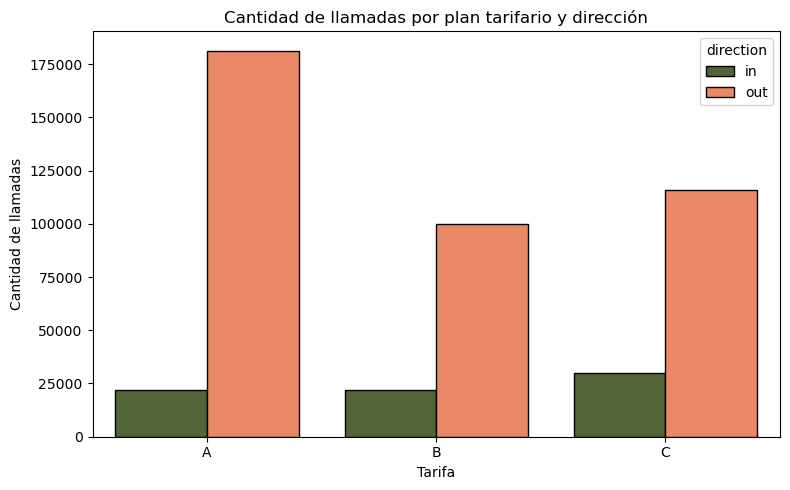

In [7421]:
tariff = clients[['user_id', 'tariff_plan']]
new_data = filtered_calls.merge(tariff, on='user_id', how='left')

# Agrupación por tarifa y dirección
direction_counts = new_data.groupby(['tariff_plan', 'direction'])['calls_count'].sum().reset_index()

custom_colors = {
    'in': '#556B2F',  
    'out': 'coral'
}   

# Gráfico con hue por tipo de llamada
plt.figure(figsize=(8, 5))
sns.barplot(data=direction_counts, x='tariff_plan', y='calls_count', hue='direction', palette=custom_colors, edgecolor='black')

plt.title('Cantidad de llamadas por plan tarifario y dirección')
plt.xlabel('Tarifa')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

El promedio de llamadas salientes esta por encima de las 100.000 llamadas, mientras que las llamadas entrantes son en promedio unas 25.000.
La tarifa A es que más llamadas salientes tiene con aproximadamente 175.000.

### Distribución de llamadas por días

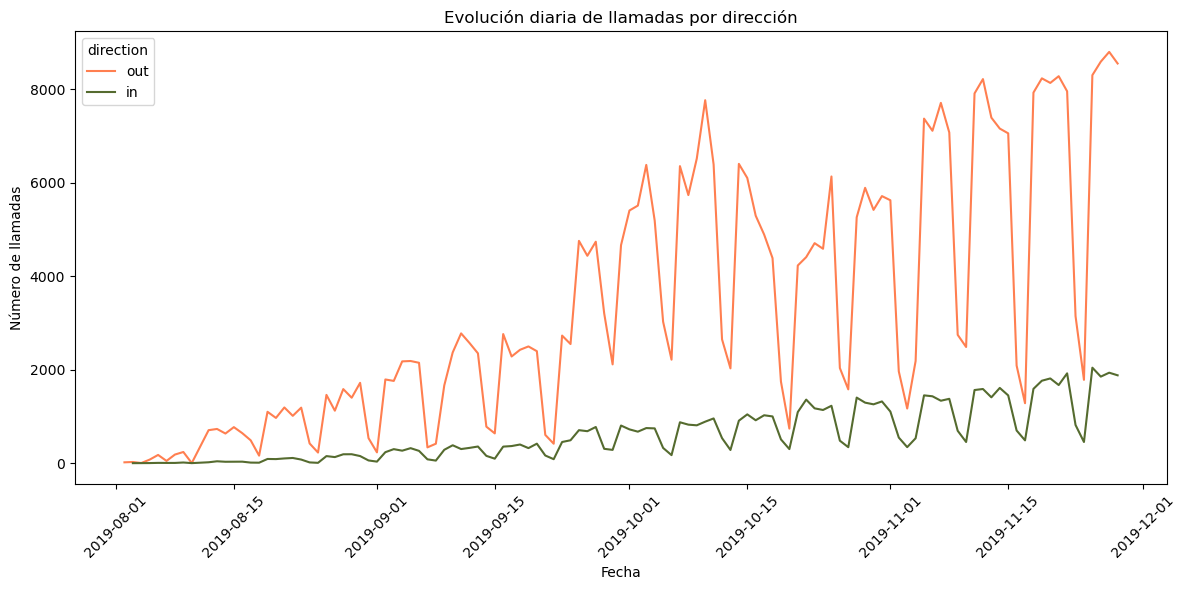

In [7422]:
calls_by_days = new_data.groupby(['date', 'direction'])['calls_count'].sum().reset_index()

custom_colors = {
    'in': '#556B2F',  
    'out': 'coral'   
}
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_days, x='date', y='calls_count', hue='direction', palette=custom_colors)
plt.title('Evolución diaria de llamadas por dirección')
plt.xlabel('Fecha')
plt.ylabel('Número de llamadas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las llamadas salientes representan un crecimiento mucho más pronunciado y significativo en comparación con las llamadas entrantes. Ambas tienen un comportamiento cíclico, es decir, crecen y decrecen casi que en igual proporción lo que podría ser dado por  los fines de semana o días no laborales.
Las llamadas salientes alcanzan valores superiores a 8000 al final del período, mientras que las entrantes no superan los 2000.

### Distribución de llamadas por dirección (in vs out):

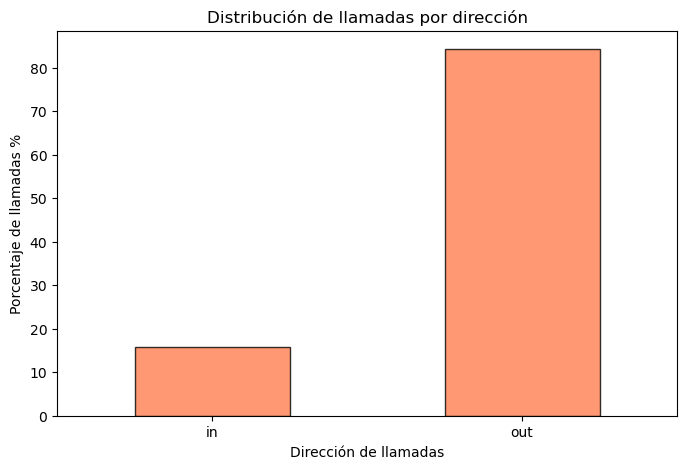

In [7423]:
# Agrupar por dirección de llamadas y cantidad

# Total de llamadas
total_calls = new_data['calls_count'].sum()

# Agrupamos llamadas por dirección y se suman
calls_by_direction = new_data.groupby('direction')['calls_count'].sum()

calls_by_direction = calls_by_direction / total_calls * 100
calls_by_direction.plot(kind='bar',  
                        color='coral', 
                        figsize=(8, 5),
                        edgecolor='black',
                        alpha=0.8,
                        title='Distribución de llamadas por dirección',
                        xlabel='Dirección de llamadas',
                        ylabel='Porcentaje de llamadas %')
plt.xticks(rotation=0)
plt.show()

Las llamadas salientes representan más del 80% del total de las llamadas

### Distribución de llamadas por operador

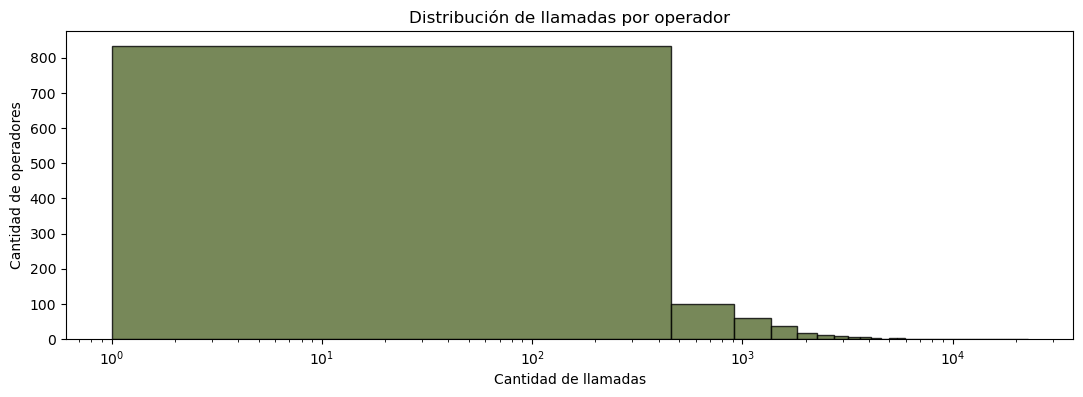

In [7424]:
# Agupamos por operador y cantidad de llamadas
calls_by_operator = new_data.groupby('operator_id')['calls_count'].sum().sort_values(ascending=False)

# Gráfica
plt.figure(figsize=(13, 4))
plt.hist(calls_by_operator, bins=50, color='#556B2F', edgecolor='black', alpha=0.8)
plt.title('Distribución de llamadas por operador')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Cantidad de operadores')
plt.xscale('log')
plt.show()

En este gráfico se aplicó la escala slogaritmica que nos permite visualizar que la mayoría de operadores realizaron muy pocas llamadas, entre 0 y 3 durante el periodo de análisis.

### Porcentaje de llamadas entrantes perdidas por operador

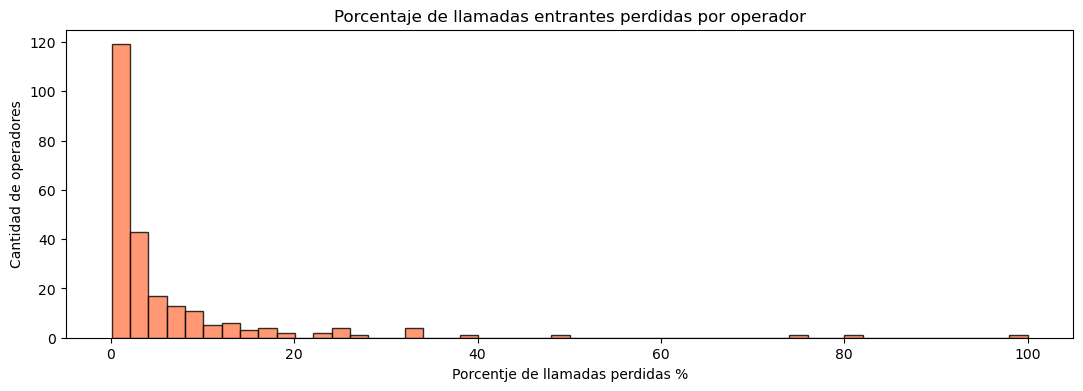

In [7425]:
# Asignamos valores booleans a la columna 'is_missed_call'
new_data['is_missed_call'] = new_data['is_missed_call'].replace({'False': 0, 'True': 1}).astype(int)

# Creamos dataset con llamadas entrantes perdidas
missed_in_calls = new_data[(new_data['direction'] == 'in') & (new_data['is_missed_call'] == 1)]
missed_calls_by_operator = missed_in_calls.groupby('operator_id')['calls_count'].sum()

# Total llamadas entrantes
in_calls = new_data[(new_data['direction'] == 'in')]

# Total de llamadas entrantes por operador
total_in_calls = in_calls.groupby('operator_id')['calls_count'].sum()

# Porcentaje de llamadas perdidas por operador
missed_calls_rate = (missed_calls_by_operator / total_in_calls) * 100
missed_calls_rate = missed_calls_rate.sort_values(ascending=False)

# Histograma de llamadas perdidas entrantes por operador
plt.figure(figsize=(13, 4))
plt.hist(missed_calls_rate,  bins=50, color='coral', edgecolor='black', alpha=0.8)
plt.title('Porcentaje de llamadas entrantes perdidas por operador')
plt.xlabel('Porcentje de llamadas perdidas %')
plt.ylabel('Cantidad de operadores')
plt.show()


En la mayoría de los operadores el porcentaje de llamadas entrantes es menos del 20%.

### Tiempo promedio de espera por operador

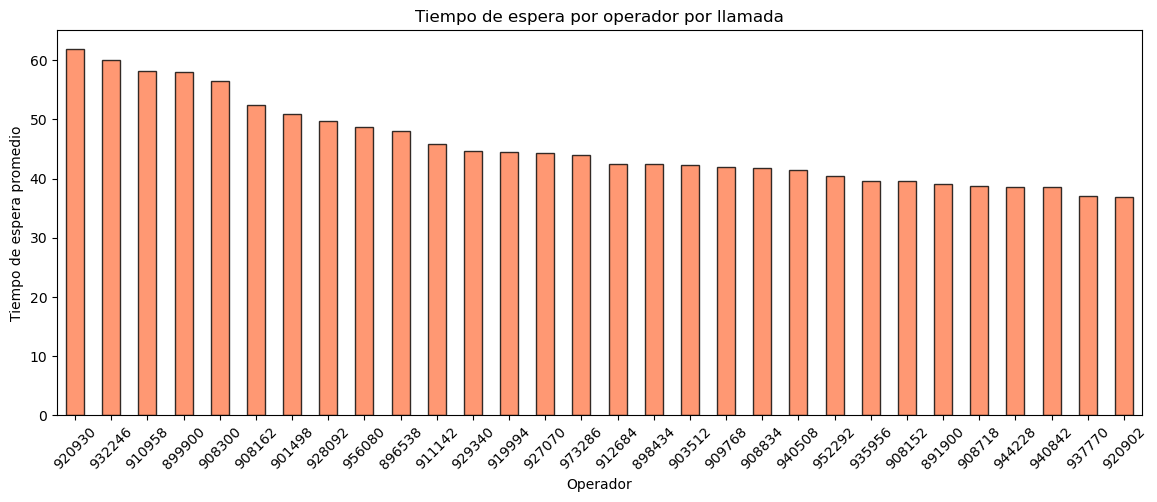

In [7426]:
# Calculamos nueva clumna del tiempo de espera
new_data['waiting_time'] = new_data['total_call_duration'] - new_data['call_duration']

new_data['avg_wait_by_call'] = new_data['waiting_time'] / new_data['calls_count']

# Histograma del tiempo de espera
new_data.groupby('operator_id')['avg_wait_by_call'].mean().sort_values(ascending=False).head(30).plot(kind='bar',
                                                figsize=(14,5),
                                                xlabel = 'Operador',
                                                ylabel = 'Tiempo de espera promedio',
                                                title = 'Tiempo de espera por operador por llamada',
                                                color='coral',
                                                rot=45,
                                                edgecolor='black',
                                                alpha=0.8 )
plt.show()

El tiempo promedio de espera de cada llamada es de 16,55 minutos.
El promedio de los primeros 20 operadores con mayor tiempo de espera es de aproximadamente unos 45 minutos.

In [7427]:
new_data['avg_wait_by_call'].describe().round(2).reset_index()

,index,avg_wait_by_call
0,count,39876.00
1,mean,16.55
2,std,11.95
3,min,0.00
4,25%,8.25
5,50%,14.36
6,75%,22.00
7,max,261.00


In [7428]:
new_data.groupby('operator_id')['avg_wait_by_call'].describe().round(2).reset_index().sort_values(by='count', ascending=False)

,operator_id,count,mean,std,min,25%,50%,75%,max
204,901884,319.0,15.39,8.93,0.00,10.00,13.65,18.71,60.00
203,901880,293.0,13.16,10.50,0.00,5.05,11.62,17.50,53.20
108,893804,288.0,12.62,9.60,0.00,4.53,13.00,18.17,61.00
33,887276,267.0,19.06,12.46,0.00,10.42,15.00,28.00,60.00
78,891410,250.0,9.35,6.42,0.00,5.46,9.11,13.16,38.00
...,...,...,...,...,...,...,...,...,...
253,905480,1.0,5.00,NaN,5.00,5.00,5.00,5.00,5.00
252,905478,1.0,36.00,NaN,36.00,36.00,36.00,36.00,36.00
55,890234,1.0,12.00,NaN,12.00,12.00,12.00,12.00,12.00
250,905470,1.0,3.33,NaN,3.33,3.33,3.33,3.33,3.33


En este descriptivo evidenciamos que no por mayor cantidad de llamadas se tiene mayor tiempo de espera, pero si se tiene aún la presencia de diferencias significativas en los tiempos de atención entre operadores, no necesariamente asociadas al volumen de llamadas, sino posiblemente a factores individuales como la eficiencia, el manejo del sistema o problemas operativos específicos.

### Llamadas salientes por operador

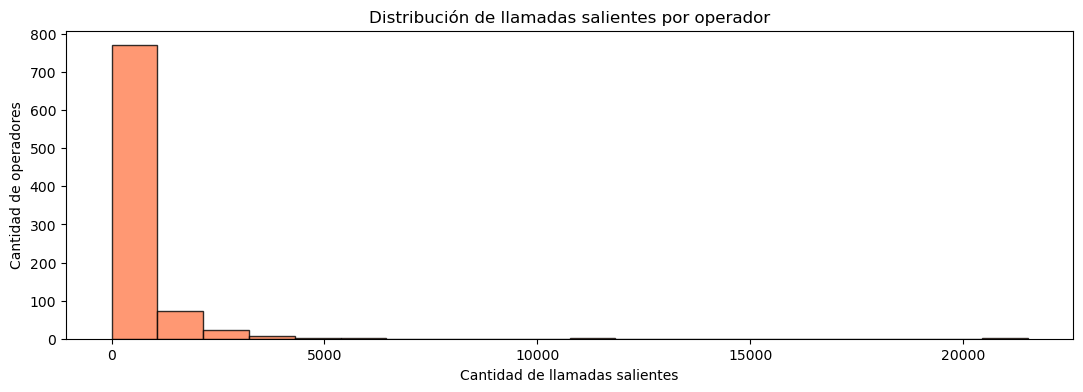

In [7429]:
# Asignamos valores booleans a la columna 'direction'
new_data['direction'] = new_data['direction'].map({'in': 0, 'out': 1}).astype(int)

# Filtrar llamadas salientes
outgoing_calls = new_data[new_data['direction'] == 1]
out_calls_by_operator = outgoing_calls.groupby(['operator_id'])['calls_count'].sum()

# Gráfica de llamadas salientes por operador
plt.figure(figsize=(13, 4))
plt.hist(out_calls_by_operator, bins=20, color='coral', edgecolor='black', alpha=0.8)
plt.title('Distribución de llamadas salientes por operador')
plt.xlabel('Cantidad de llamadas salientes')
plt.ylabel('Cantidad de operadores')    
plt.show()

In [7430]:
print(f' De los 1092 operadores en total, {len(out_calls_by_operator[out_calls_by_operator <= 100])} tienen menos de 100 llamadas salientes.')

 De los 1092 operadores en total, 453 tienen menos de 100 llamadas salientes.


In [7431]:
# Llamadas salientes por día y operador

out_calls_by_day_operator = outgoing_calls.groupby(['date', 'operator_id'])['calls_count'].sum().sort_values(ascending=False).reset_index()
out_calls_by_day_operator['calls_count'].describe().round(2).to_frame().reset_index()

,index,calls_count
0,count,15052.00
1,mean,26.36
2,std,45.60
3,min,1.00
4,25%,3.00
5,50%,10.00
6,75%,31.00
7,max,499.00


### Correlación entre variables

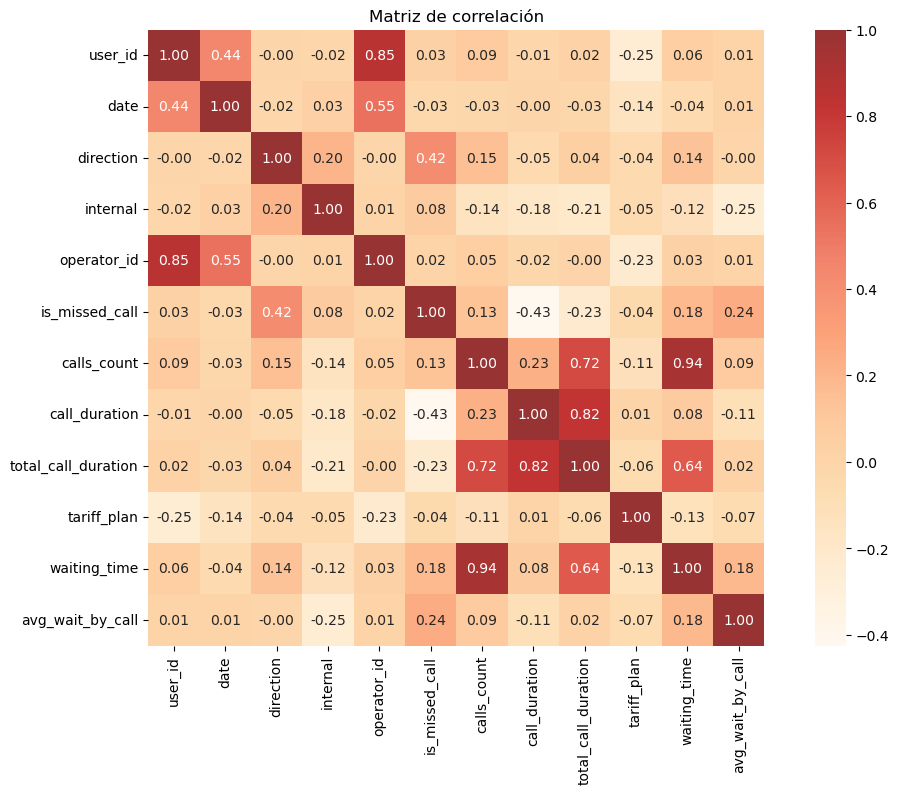

In [7432]:
# Asignamos valores boleanos a la columna 'tariff_plan'

# Asignamos valores a la columna 'direction'
new_data['tariff_plan'] = new_data['tariff_plan'].map({'A': 1, 'B': 2, 'C': 3}).astype(int)

# Calculamos la matriz de correlación entre las variables
corr = new_data.corr()

# Gráficamos la matriz de correlación con un mapa de calor
plt.figure(figsize=(13, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='OrRd', square=True, alpha=0.8)
plt.title('Matriz de correlación')
plt.show()

In [7433]:
new_data['operator_id'].nunique()

1092

El tiempo de espera y el total de llamadas por usuario tienen una correlación fuerte.

## Análisis de operadores ineficaces

Los 3 conceptos para determinar si un operador es ineficas son:

1. Gran cantidad de llamadas entrantes perdidas (internas y externas) 
2. Un tiempo de espera prolongado para las llamadas entrantes
3. Un número reducido de llamadas 

Basados en estas tres variables con igual importancia, buscaremos una métrica que nos ayude a definir cuantos operadores de los 1092 son ineficaces. Para lo cual a cada variable se le asigna un valor de 0.3333

In [7434]:
# Filtramos llamadas entrantes
incoming_calls = new_data[new_data['direction'] == 0]

# Llamadas perdidas por operador
missed_calls = incoming_calls[incoming_calls['is_missed_call'] == 1].groupby('operator_id')['calls_count'].sum().rename('missed_calls')

# Tiempo promedio de espera
avg_waiting = incoming_calls.groupby('operator_id')['waiting_time'].mean().rename('avg_waiting')

# Combinamos en un solo dataframe
operators_score = missed_calls.to_frame().join(avg_waiting, how='outer').fillna(0)

# Llamadas salientes por operador
outgoing_calls = new_data[new_data['direction'] == 1].groupby('operator_id')['calls_count'].sum().rename('outgoing_calls')

# Unimos llamadas salientes
operators_score = operators_score.join(outgoing_calls, how='outer').fillna(0)

# Estandarización
scaler = MinMaxScaler()
scaled = scaler.fit_transform(operators_score[['missed_calls', 'avg_waiting', 'outgoing_calls']])
operators_score[['missed_calls_scaled', 'avg_waiting_scaled', 'out_calls_scaled']] = scaled

# Puntaje de ineficacia (más alto = peor desempeño)
operators_score['inefficiency_score'] = (0.333 * operators_score['missed_calls_scaled'] +
    0.333 * operators_score['avg_waiting_scaled'] +
    0.333 * (1 - operators_score['out_calls_scaled']))

# Ordenamos por ineficiencia descendente
operators_score = operators_score.sort_values('inefficiency_score', ascending=False).round(2)

operators_score


,missed_calls,avg_waiting,outgoing_calls,missed_calls_scaled,avg_waiting_scaled,out_calls_scaled,inefficiency_score
operator_id,,,,,,,
913942,52.0,209.88,440.0,1.00,0.21,0.02,0.73
919794,1.0,991.32,21.0,0.02,1.00,0.00,0.67
919790,0.0,866.80,23.0,0.00,0.87,0.00,0.62
944226,30.0,153.58,109.0,0.58,0.15,0.01,0.58
919554,11.0,503.16,11.0,0.21,0.51,0.00,0.57
...,...,...,...,...,...,...,...
945286,0.0,0.00,4951.0,0.00,0.00,0.23,0.26
879898,0.0,29.47,5654.0,0.00,0.03,0.26,0.26
929426,0.0,0.00,5028.0,0.00,0.00,0.23,0.26


In [7435]:
# Estadisticas descriptivas
operators_score['inefficiency_score'].describe().round(2).reset_index()

,index,inefficiency_score
0,count,1092.00
1,mean,0.34
2,std,0.04
3,min,0.21
4,25%,0.33
5,50%,0.34
6,75%,0.35
7,max,0.73


El 75% de los operadores tiene un puntaje de ineficiencia del 35%, por lo que podemos establecer este como el umbral para decir si un operador es o no ineficiente.

In [7436]:
# Filtramos operadores ineficaces que su puntaje sea mayor a 0.35
inefficient_operators = operators_score[operators_score['inefficiency_score'] > 0.35].reset_index()

print(f'Hay {len(inefficient_operators["operator_id"])} operadores con un puntaje de ineficacia superior al 35%.')

Hay 189 operadores con un puntaje de ineficacia superior al 35%.


## Prueba de hipótesis

Las hipótesis se evaluarán a través del coeficiente de correlación de Spearman, ya que permite analizar la relación entre dos variables incluso cuando presentan valores discretos y atípicos.

Esta elección es adecuada dado que, aunque se eliminaron algunos valores extremos, siguen existiendo diferencias significativas entre operadores en las tres métricas analizadas: llamadas entrantes perdidas (missed_calls), tiempo promedio de espera (avg_waiting) y cantidad de llamadas salientes (outgoing_calls).

### Los operadores más eficaces tienen mayor número de llamadas salientes.


H0 : No existe una relación estadísticamente significativa entre llamadas salientes y el puntaje de ineficiencia.

H1 : Existe una relación estadísticamente significativa entre llamadas salientes y el puntaje de ineficiencia.

In [7437]:
# Extraemos las variables
x = operators_score['outgoing_calls']
y = operators_score['inefficiency_score']

alpha = 0.05
corr, p_value = spearmanr(x, y)

print(f"Spearman correlation: {corr:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Se rechaza H0: Existe una relación estadísticamente significativa entre llamadas salientes y el puntaje de ineficiencia.")
    if corr < 0:
        print("Relación negativa: cuantos más llamados salientes realiza un operador, menor es su ineficiencia.")
    else:
        print("Relación positiva: cuantos más llamados salientes realiza un operador, mayor es su ineficiencia.")
else:
    print("No se rechaza H0: No se encontró evidencia de una relación significativa entre llamadas salientes y la ineficiencia.")

Spearman correlation: -0.27
P-value: 0.0000
Se rechaza H0: Existe una relación estadísticamente significativa entre llamadas salientes y el puntaje de ineficiencia.
Relación negativa: cuantos más llamados salientes realiza un operador, menor es su ineficiencia.


### Los operadores con menor tiempo de espera y mayor cantidad de llamadas salientes son más eficientes.


H0: No Existe una relación significativa entre las variables tiempo de espera y llamadas salientes.

H1 : Existe una relación significativa entre las variables tiempo de espera y llamadas salientes.

In [7438]:
# Extraemos las variables
x = operators_score['avg_waiting']
y = operators_score['outgoing_calls']

alpha = 0.05
# Calculamos la correlación de Spearman
corr, p_value = spearmanr(x, y)

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Se rechaza H0: Existe una relación significativa entre las variables.")
    if corr > 0:
        print("Es una relación positiva: a mayor tiempo de espera, más llamadas salientes.")
    else:
        print("Es una relación negativa: a mayor tiempo de espera, menos llamadas salientes.")
else:
    print(" No se rechaza H0: No hay evidencia de relación significativa.")

Spearman correlation: -0.046614971248363585
P-value: 0.12368614742966894
 No se rechaza H0: No hay evidencia de relación significativa.


### Los operadores con menor tiempo de espera y menor cantidad de llamadas entrantes perdidas son más eficientes.


H0: No Existe una relación significativa entre las variables tiempo de espera y llamadas entrantes perdidas.

H1 : Existe una relación significativa entre las variables tiempo de espera y llamadas entrantes perdidas.

In [7439]:
# Extraemos las variables
x = operators_score['avg_waiting']
y = operators_score['missed_calls']

alpha = 0.05
# Calculamos la correlación de Spearman
corr, p_value = spearmanr(x, y)

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Se rechaza H0: Existe una relación significativa entre las variables.")
    if corr > 0:
        print("Es una relación positiva: a mayor tiempo de espera, más llamadas entrantes perdidas.")
    else:
        print("Es una relación negativa: a mayor tiempo de espera, menos llamadas perdidas (inesperado).")
else:
    print(" No se rechaza H0: No hay evidencia de relación significativa.")

Spearman correlation: 0.5047729362890365
P-value: 1.1720256776259908e-71
Se rechaza H0: Existe una relación significativa entre las variables.
Es una relación positiva: a mayor tiempo de espera, más llamadas entrantes perdidas.


### Cantidad de operadores ineficientes por tarifa

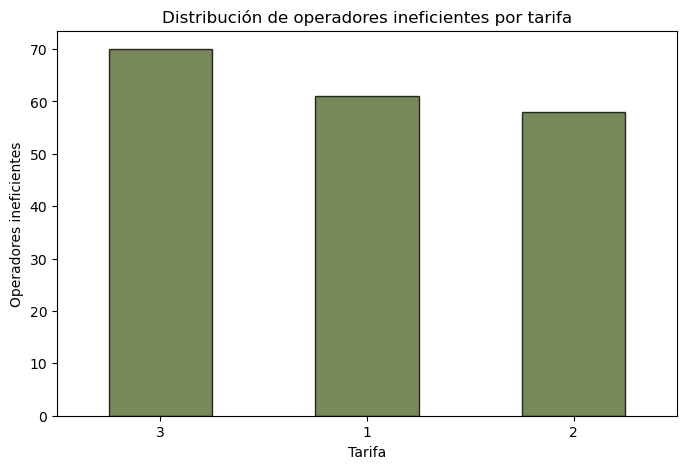

In [7440]:
# Extraer tabla con operador y tarifa desde new_data
operator_tariffs = new_data[['operator_id', 'tariff_plan']].drop_duplicates()

# Unimos las tarifas de los operadores ineficientes
operator_tariffs = inefficient_operators.merge(operator_tariffs, on='operator_id', how='left')
operator_tariffs.groupby('tariff_plan')['operator_id'].count().sort_values(ascending=False).plot(kind='bar',  
                         color='#556B2F', 
                         figsize=(8, 5),
                         edgecolor='black',
                         alpha=0.8,
                         title='Distribución de operadores ineficientes por tarifa',
                         xlabel='Tarifa',
                         ylabel='Operadores ineficientes')
plt.xticks(rotation=0)
plt.show()

Los 189 operadores clasificados como ineficacez estan presentes en las tres tarifas con proporciones muy similares, siendo la tarifa C la que más operarodes ineficientes tiene con aproximadamente 70.

In [7441]:
# Exportamos dataset filtrado a un nuevo archivo CSV para usarlo en el dashboard
new_data.to_csv('new_data.csv', index=False)

## Recursos consultados:
1. https://docs.snowflake.com/en/sql-reference/data-types-datetime
Se uso para comprobar el tipo de dato que se representa en la columna date. MARCA DE TIEMPO_TZ, puesto que almacena fecha, hora más la diferencia de zona horaria.
2. https://matplotlib.org/stable/users/explain/axes/axes_scales.html
Se uso para graficar el histograma de distribución de llamadas por operador con escala logarítmica, con el fin de visualizar mucho mejor la cantidad de operadores con baja cantidad de llamadas.
3. https://4geeks.com/es/lesson/escalado-de-caracteristicas Consulta sobre el método adecuado para el escalado de las características.
4. https://datatab.es/tutorial/spearman-correlation para prueba estadistica de correlación entre dos variable que no requiere distribución normal, con valores discretos y presencia de valores atípicos.
5. Todos los recursos de los modulos de Tripleten en el bootcamp de análisis de datos fueron usados.
6. Chat gpt o herramientas AI para ciertas funciones no vistas a lo largo del curso y que me ayudaban a solucionar error, ejemplo: .map() que se uso para reemplazar los valores de la columna de la direction y tarifa, ya que con .replace() me salia advertencia.


## Conclusiones

1. Aún después de eliminar registros de usuarios con valores atípicos en las cantidad y duración de llamadas, se concluye una gran diferencia entre los operadores, algunos con 499 llamadas salientes al día otros con tan solo 1, inicialmente se pensó que podría inferir el plan tarifario que tenía el cliente, pero en realidad estas 2 variables no tienen una correlación fuerte y todos los operadores se usan en las 3 tarifas y en las 3 tarifas hay operadores ineficientes.

2. Se puedo evidenciar hay una correlación fuerte entre el número de llamadas y el tiempo de espera total por operador. Pero como existe una diferencia tan grande entre algunos operadores con muchas llamadas y otros con unas cuantas, se calculó y se gráfico la variable del tiempo promedio x llamada, la cual  pone en una balanza más justa a todos lo operadores.

3. Las hipótesis se evaluaron a través del coeficiente de correlación de Spearman, ya que permite analizar la relación entre dos variables incluso cuando presentan valores discretos y atípicos.
La elección de esta método se debe a que aún después de eliminar algunos valores extremos, siguen existiendo diferencias significativas entre operadores en las tres métricas analizadas: llamadas entrantes perdidas (missed_calls), tiempo promedio de espera (avg_waiting) y cantidad de llamadas salientes (outgoing_calls).

4. Se puedo evidenciar hay una correlación fuerte entre el número de llamadas y el tiempo de espera total por operador. Pero como existe una diferencia tan grande entre algunos operadores con muchas llamadas y otros con unas cuantas, se calculó y se gráfico la variable del tiempo promedio x llamada, la cual  pone en una balanza más justa a todos lo operadores.

5. Se concluye que no por mayor cantidad de llamadas salientes se tiene mayor tiempo de espera, pero aún así se evidencia en los estadísticos descriptivos que si hay la presencia de diferencias significativas en los tiempos de atención entre operadores, no necesariamente asociadas al volumen de llamadas, sino posiblemente a factores individuales como la eficiencia, el manejo del sistema o problemas operativos específicos.